In [88]:
import glob
import sys
import os

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix, accuracy_score

In [89]:
sys.path.append(os.path.abspath('../src'))

from read_and_write_docs import read_jsonl, write_jsonl, read_rds
from performance import performance, performance_paraphrase

# Paraphrase V2

Paraphrase v2 is the LambdaG code in its traditional form where we lump all of the paraphrased sentences together and randomly sample them for the same number as in the known document.

Accidentally kept the r at 100

In [90]:
v2_dir = "/Volumes/BCross/datasets/author_verification/lambda_g_results/paraphrase_v2/Wiki-training"

In [93]:
import glob


jsonl_files = glob.glob(f"{v2_dir}/*.jsonl")
sorted(jsonl_files)

print(jsonl_files)

['/Volumes/BCross/datasets/author_verification/lambda_g_results/paraphrase_v2/Wiki-training/gen_t_0.7.jsonl', '/Volumes/BCross/datasets/author_verification/lambda_g_results/paraphrase_v2/Wiki-training/gen_t_1.5.jsonl', '/Volumes/BCross/datasets/author_verification/lambda_g_results/paraphrase_v2/Wiki-training/sim_t_0.7.jsonl', '/Volumes/BCross/datasets/author_verification/lambda_g_results/paraphrase_v2/Wiki-training/sim_t_1.0.jsonl', '/Volumes/BCross/datasets/author_verification/lambda_g_results/paraphrase_v2/Wiki-training/sim_t_1.2.jsonl', '/Volumes/BCross/datasets/author_verification/lambda_g_results/paraphrase_v2/Wiki-training/sim_t_1.5.jsonl', '/Volumes/BCross/datasets/author_verification/lambda_g_results/paraphrase_v2/Wiki-training/gen_t_1.2.jsonl']


In [94]:
data = read_jsonl(jsonl_files[-1])

In [79]:
data = read_jsonl('/Volumes/BCross/datasets/author_verification/training/Wiki/Qwen_2.5_1.5B/gen_t_1.5_tp_0.9/lambda_g_results.jsonl')

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [95]:
grouped_data = (
    data
    .groupby(['problem', 'target'], as_index=False)
    ['score']
    .mean()
)

In [96]:
grouped_data

,problem,target,score
0,142.196.88.228 vs 142.196.88.228,True,57208.327733
1,142.196.88.228 vs Aban1313,False,35437.992193
2,A_Man_In_Black vs A_Man_In_Black,True,46709.178468
3,A_Man_In_Black vs Bankhallbretherton,False,22239.668440
4,Aban1313 vs Aban1313,True,44237.091032
...,...,...,...
145,Haymaker vs HeadleyDown,False,40934.073060
146,HeadleyDown vs HeadleyDown,True,54255.947065
147,HeadleyDown vs Hipocrite,False,30600.292670
148,Hipocrite vs Hipocrite,True,32027.258188


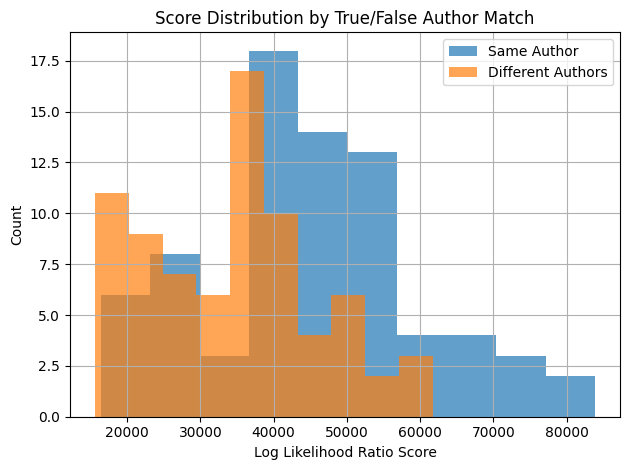

In [97]:
# Plot histogram of scores by target
plt.figure()
grouped_data[grouped_data['target'] == True]['score'].hist(alpha=0.7, label='Same Author')
grouped_data[grouped_data['target'] == False]['score'].hist(alpha=0.7, label='Different Authors')
plt.title('Score Distribution by True/False Author Match')
plt.xlabel('Log Likelihood Ratio Score')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

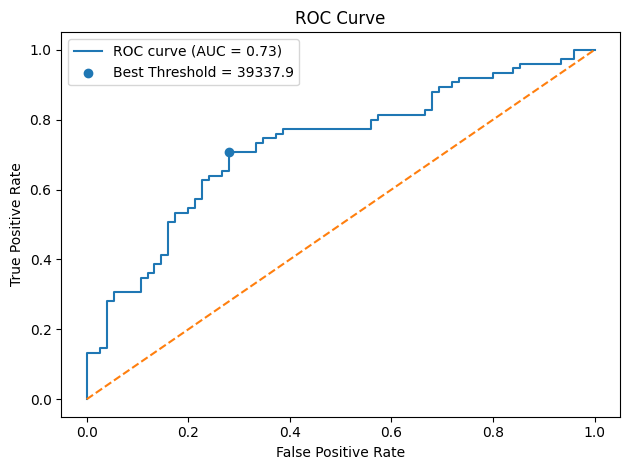

In [98]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(grouped_data['target'], grouped_data['score'])
roc_auc = auc(fpr, tpr)

# Determine best threshold (Youden's J statistic)
youden_j = tpr - fpr
best_idx = youden_j.argmax()
best_threshold = thresholds[best_idx]

# Compute metrics at best threshold
preds = grouped_data['score'] >= best_threshold
f1 = f1_score(grouped_data['target'], preds)
accuracy = accuracy_score(grouped_data['target'], preds)
cm = confusion_matrix(grouped_data['target'], preds)
cm_df = pd.DataFrame(cm, index=['Actual False', 'Actual True'], columns=['Predicted False', 'Predicted True'])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr[best_idx], tpr[best_idx], marker='o', label=f'Best Threshold = {best_threshold:.1f}')
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()

In [99]:
# Display metrics and confusion matrix
print(f"Optimal Threshold (Youden's J): {best_threshold:.3f}")
print(f"AUC: {roc_auc:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")

Optimal Threshold (Youden's J): 39337.865
AUC: 0.727
F1 Score: 0.711
Accuracy: 0.713


In [100]:
cm_df

,Predicted False,Predicted True
Actual False,54,21
Actual True,22,53


In [101]:
score_col = 'score'
target_col = 'target'
performance(grouped_data,
            score_col,
            target_col,
            additional_metadata={
                'corpus': "Wiki-training"
            })

,corpus,Cllr,Cllr_min,EER,Mean_TRUE_LLR,Mean_FALSE_LLR,TRUE_trials,FALSE_trials,AUC,Balanced_Accuracy,Precision,Recall,F1,TP,FP,FN,TN
0,Wiki-training,0.90451,0.90451,0.32,0.145338,-0.132017,75,75,0.713244,0.686667,0.684211,0.693333,0.688742,52,24,23,51


In [102]:
score_col = 'score'
target_col = 'target'
performance_paraphrase(grouped_data,
            score_col,
            target_col,
            additional_metadata={
                'corpus': "Wiki-training"
            })

,corpus,Cllr,Cllr_min,EER,Mean_TRUE_LLR,Mean_FALSE_LLR,TRUE_trials,FALSE_trials,AUC,Balanced_Accuracy,Precision,Recall,F1,TP,FP,FN,TN
0,Wiki-training,0.904458,0.904458,0.32,0.14547,-0.131958,75,75,0.713067,0.686667,0.684211,0.693333,0.688742,52,24,23,51
